
# T2 - LA2ML - Sistemas de Recomendacao com Filtragem Colaborativa e SVD
Arthur Rezende Salles da Costa - 166003 
---
---   

In [1]:
import pandas as pd 
import numpy as np
import os 
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')
from sklearn.impute import KNNImputer

from sklearn.metrics import mean_absolute_error,  root_mean_squared_error

---
## Implementacao SVD

In [ ]:
A = np.array([[1, 0, 1], [-2, 1, 8]])
random_matrix = np.random.rand(10,20)

def my_svd(A):

    ata = np.dot(A.T, A)

    eigenvalues, eigenvectors = np.linalg.eigh(ata)

    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore") # ignore np.sqrt warnings about 0 or negative values, even though it works a warning is raised
        sing_values = np.nan_to_num(np.sqrt(eigenvalues), True, 0)
        sorted_singular_values = np.argsort(sing_values)[::-1]
        V = eigenvectors[:, sorted_singular_values]
        U = np.dot(A, V) / sing_values[sorted_singular_values]

    sigma = sing_values[sorted_singular_values]

    if A.shape[0] < A.shape[1]:
        U = U[:, :min(A.shape)]
        sigma = sigma[:min(A.shape)]


    return U, sigma, V.T

my_u, my_sigma, my_vt = my_svd(random_matrix)
u, sigma, vt = np.linalg.svd(random_matrix)


similarity_u = np.allclose(np.abs(my_u), np.abs(u))
similarity_sigma = np.allclose(np.abs(my_sigma), np.abs(sigma))
similarity_vt = np.allclose(np.abs(my_vt), np.abs(vt))

print(f"Are both implementations abs similar enough? (tol=1e-05)\nSimilarities:\nU={similarity_u}\nSigma={similarity_sigma}\nVt={similarity_vt}")

my_u, my_sigma, my_vt = my_svd(A)
u, sigma, vt = np.linalg.svd(A)
print("-"* 55 )

similarity_u = np.allclose(my_u, u)
similarity_sigma = np.allclose(my_sigma, sigma)
similarity_vt = np.allclose(my_vt, vt)


print(f"Are both implementations similar enough? (tol=1e-05)\nSimilarities:\nU={similarity_u}\nSigma={similarity_sigma}\nVt={similarity_vt}")
print("-"* 55 )
print(my_vt,'\n', '-' * 40,'\n', vt)

Are both implementations abs similar enough? (tol=1e-05)
Similarities:
U=True
Sigma=True
Vt=False
-------------------------------------------------------
Are both implementations similar enough? (tol=1e-05)
Similarities:
U=False
Sigma=True
Vt=False
-------------------------------------------------------
[[-0.22829311  0.11945297  0.96623664]
 [ 0.96854444 -0.0730673   0.23787147]
 [-0.09901475 -0.99014754  0.09901475]] 
 ---------------------------------------- 
 [[ 0.22829311 -0.11945297 -0.96623664]
 [-0.96854444  0.0730673  -0.23787147]
 [-0.09901475 -0.99014754  0.09901475]]


As shown in the previous cell, both implementations do produce the same results, but with some difference in signal for the Vt matrix. But considering is just a matter about rows multiplied by minus one, it should not be a problem


---   

## Data Reading

In [3]:
def read_data_ml100k():
    # code extracted from -> https://www.d2l.ai/chapter_recommender-systems/movielens.html
    data_dir = "../t2/data/ml-100k"
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), sep='\t',
                       names=names, engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

data, num_users, num_items = read_data_ml100k()

average_ratings_per_user = data.groupby('user_id')['rating'].mean().reset_index()

display(data.describe())
display(data.head())

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


With the read csv the data will be organized in a matrix $X$. Which is $M$ x $N$ , $M$ is the number of users and $N$ the number of items. $X_{ij}$ means the rate for the user $i$ to the movie $j$  



---
## Matrix Building 
    - Zero filled values ( default )
    - User average ratings 
    

In [4]:
def build_matrix(data):

    m = data.user_id.unique().shape[0]
    n = data.item_id.unique().shape[0]

    X = np.zeros((m + 1, n + 1)) # adding one extra (row, col) pair so user_id and item_id matches matrix index

    for (user_id, item_id, rating, _) in data.values:
        X[user_id, item_id] = rating

    return X 

X = build_matrix(data)
X_sparsity = 1 - (np.count_nonzero(X) / float(X.size))

print(f"X initial is {X_sparsity*100:.2f}%")

def build_average_filled_matrix(X, avg_df, n):

    avg_list = avg_df['rating'].values 
    avg_ratings_matrix = np.repeat(avg_list[:, np.newaxis], X.shape[-1], axis=1)
    avg_ratings_matrix = np.insert(avg_ratings_matrix, 0, np.zeros(X.shape[-1]), axis=0)
    n_X = np.copy(X)
    n_X[n_X == 0] = avg_ratings_matrix[n_X == 0]
    return n_X 

X_average = build_average_filled_matrix(X, average_ratings_per_user, data.item_id.unique().shape[0])
X_average_sparsity = 1 - (np.count_nonzero(X_average) / float(X_average.size))
print(f"X_average sparsity is {X_average_sparsity*100:.2f}%")


X initial is 93.71%
X_average sparsity is 0.11%


X is highly sparse, which means only 7% of the matrix is really data. The remaining 93% is data inputted with zeros, for the X_average the proportions are the same but with the average rating by the user. this is:

Zero filled matrix : `X_ij = 0 if not R_ij else R_ij`


Average filled matrix `X_ij = avg(X_i) if not R_ij else R_ij`


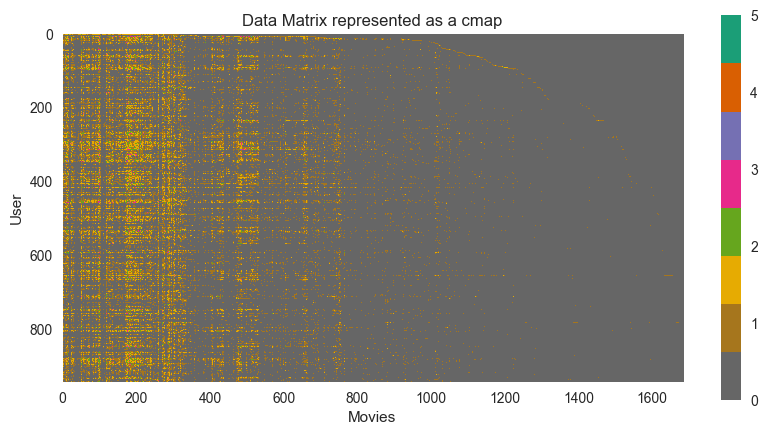

In [5]:
def ilustrate_X(X, title=None):

    fig = plt.figure(figsize=(10,5))
    plt.title("Data Matrix represented as a cmap" if title is None else title)
    plt.imshow(X, cmap='Dark2_r')
    plt.colorbar()
    plt.grid(False)
    plt.xlabel("Movies")
    plt.ylabel("User")
    plt.show()


ilustrate_X(X)

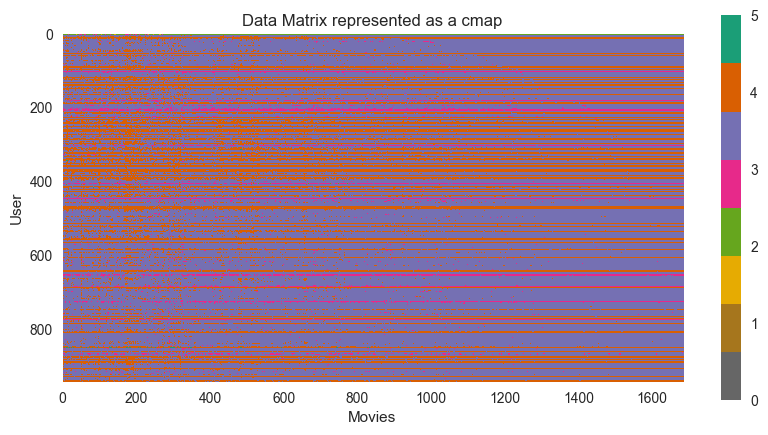

In [6]:
ilustrate_X(X_average)

The data is divided in both train and test set, following a user based indexing, i.e. spliting by users not samples, this is done to prevent tainted users (data from the same user in both training and test cases). 

This type of split is ostensibly used in health based applications, even showing lower numerical results such as accuracy and precision its still considered the best approach to produce realiable, unbiased and trustworthy models.      

(754,) (189,)


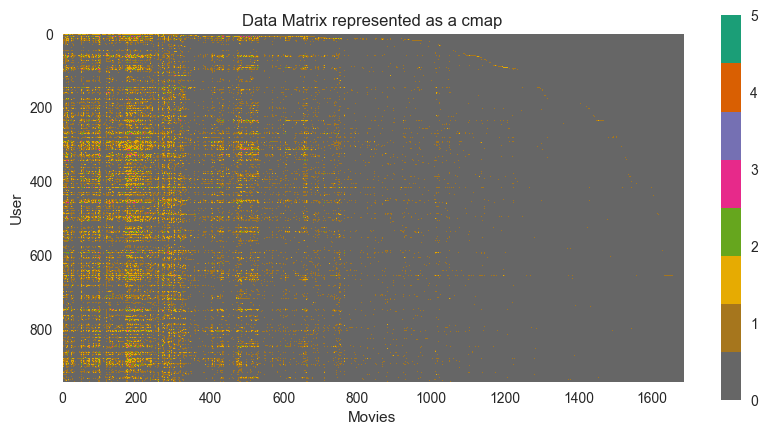

In [7]:
train_users, test_users = train_test_split(data.user_id.unique(), test_size=0.2, random_state=166003)
print(train_users.shape, test_users.shape)

# setting X train matrix
new_X = np.copy(X)
new_X[test_users] = 0
train_x = new_X
test_x = X[test_users]


ilustrate_X(train_x)



---
## SVD Decomposition - Zero filled values and user average ratings

In [8]:
# svd decomposition using numpy 
def get_svd_matrices(train_x, svd_foo=my_svd):
    train_u, train_sigma, train_vt = svd_foo(train_x)
    
    # filling sigma matrix to be proper M x N , not diag
    train_sigma_ = np.zeros((len(train_sigma), len(train_vt)))
    train_sigma_[:len(train_sigma), :len(train_sigma)] = np.diag(train_sigma)
    
    return train_u, train_sigma_, train_vt 

def ilustrate_svd(u, sigma, v, title=None):
    data = [u, sigma, v]
    legend = ['U matrix', 'Sigma', 'Vt Matrix']
    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    ax[0].set_ylabel('User Id')
    for i in range(3):
        im = ax[i].imshow(data[i],cmap='Dark2_r', aspect='auto')
        ax[i].grid(False)
        ax[i].set_title(legend[i])
    fig.colorbar(im, fraction=0.05)
    fig.tight_layout()
    plt.show()

REDUCTION_FACTOR = 0.5

# a function to reduce the matrix sizes by a percentage factor
def get_reduced_matrices(u, sigma, vt, factor=REDUCTION_FACTOR):
    assert factor <= 1 and factor >= 0, "factor must be betweeen 0 and 1 "
    
    reduced_u_ = np.int32(u.shape[0] * factor)
    reduced_sigma_ = np.array(sigma.shape * np.array(factor)).astype(np.int32)
    reduced_vt_ = np.int32(vt.shape[0] * factor)

    return u[:, :reduced_u_], sigma[:reduced_sigma_[0], :reduced_sigma_[1]], vt[:reduced_vt_, :]

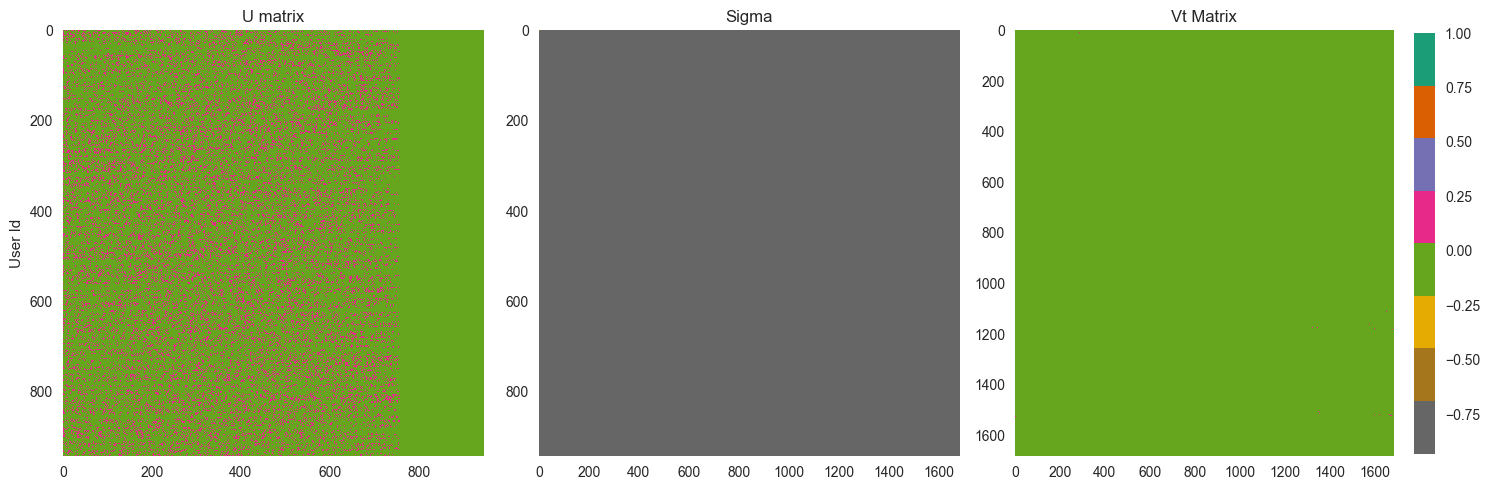

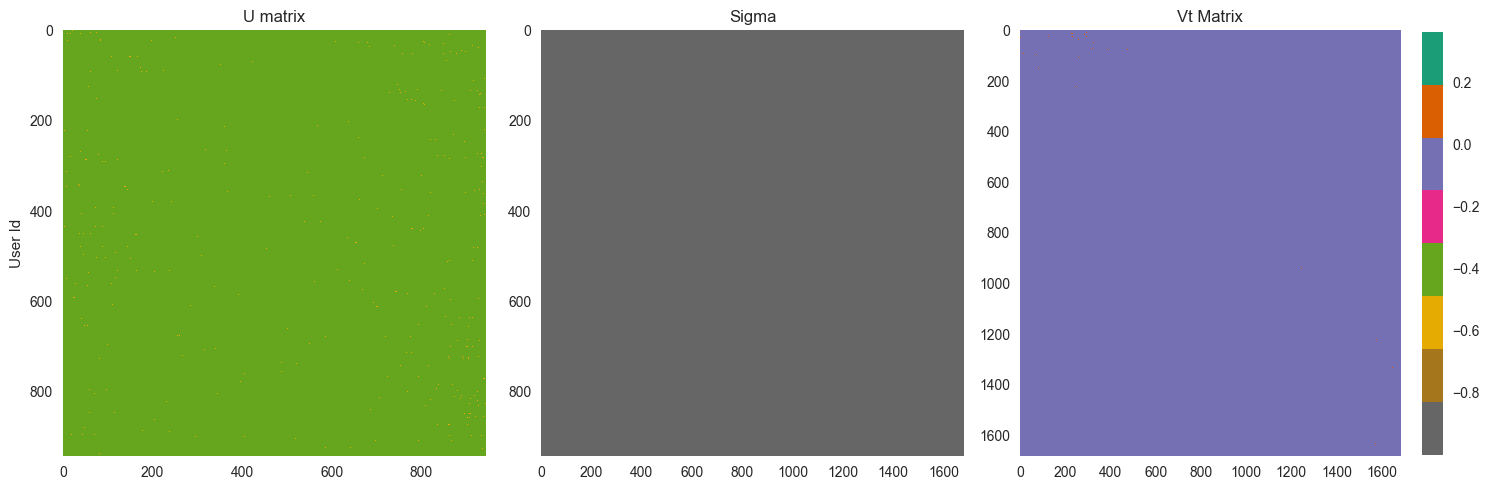

In [9]:
# default matrices -> missings filled with zeros
train_u, train_sigma_, train_vt = get_svd_matrices(train_x)
# average matrices -> missings filled with average user rating
train_u_average, train_sigma_average, train_vt_average = get_svd_matrices(X_average)

ilustrate_svd(train_u, train_sigma_, train_vt)
ilustrate_svd(train_u_average, train_sigma_average, train_vt_average)




(944, 472) (472, 841) (841, 1683)
(944, 472) (472, 841) (841, 1683)


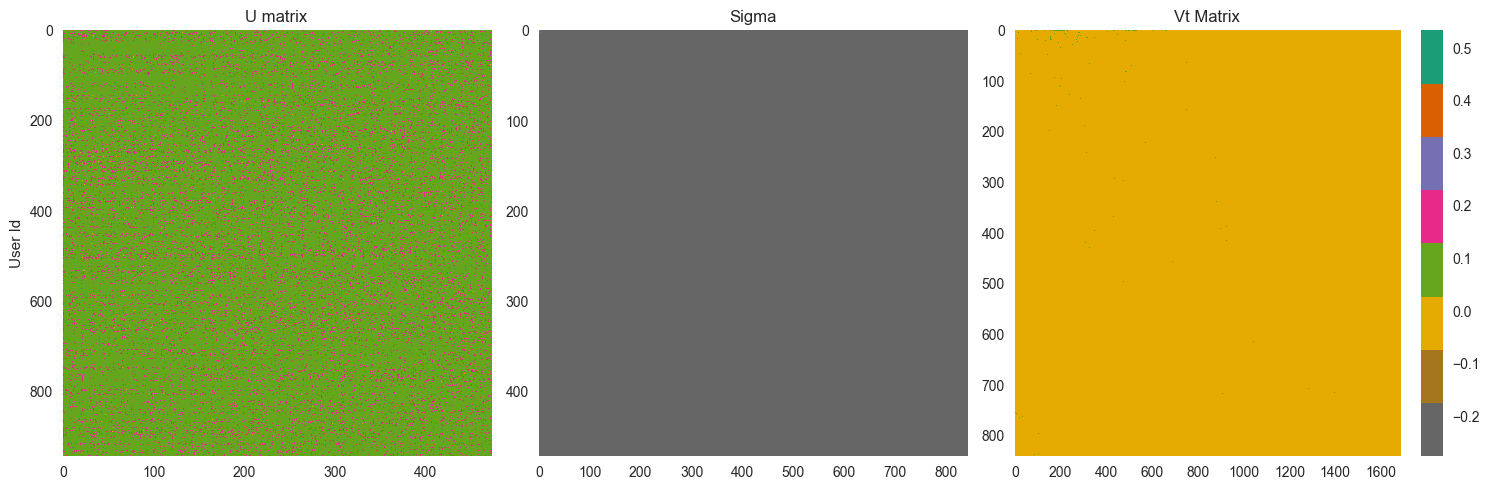

Reconstructed matrix size: (944, 1683)
Reconstruction initial sparsity is 21.74%


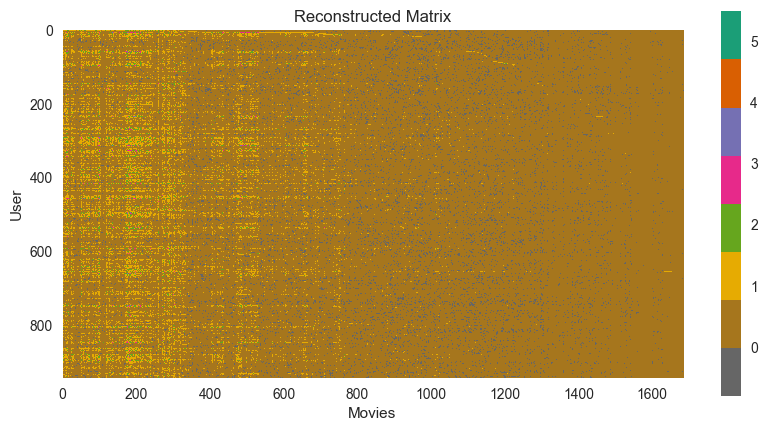

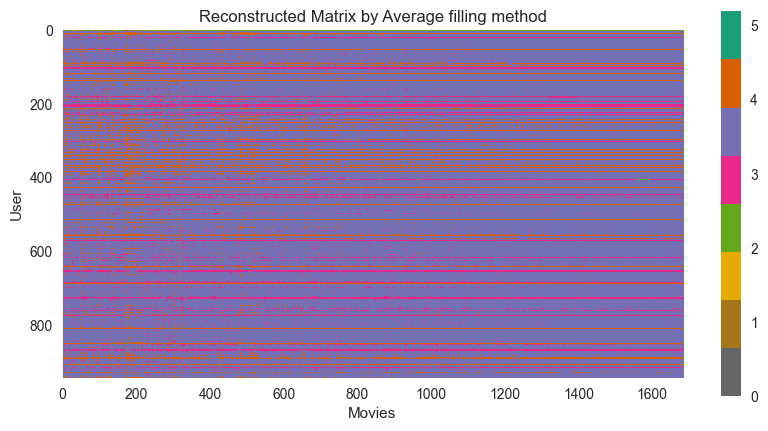

In [10]:
reduced_train_u_, reduced_train_sigma_, reduced_train_vt_ = get_reduced_matrices(train_u, train_sigma_, train_vt)

reduced_train_u_average, reduced_train_sigma_average, reduced_train_vt_average = get_reduced_matrices(train_u_average, train_sigma_average, train_vt_average)


print(reduced_train_u_.shape, reduced_train_sigma_.shape, reduced_train_vt_.shape)
print(reduced_train_u_average.shape, reduced_train_sigma_average.shape, reduced_train_vt_average.shape)

ilustrate_svd(reduced_train_u_, reduced_train_sigma_, reduced_train_vt_)

reconstruction = (reduced_train_u_ @ reduced_train_sigma_) @ reduced_train_vt_
reconstruction_average = (reduced_train_u_average @ reduced_train_sigma_average) @ reduced_train_vt_average
print('Reconstructed matrix size:', reconstruction.shape)

reconstruction_sparsity = 1 - (np.count_nonzero(reconstruction) / float(reconstruction.size))
print(f"Reconstruction initial sparsity is {reconstruction_sparsity*100:.2f}%")
ilustrate_X(reconstruction,title='Reconstructed Matrix')
ilustrate_X(reconstruction_average,title='Reconstructed Matrix by Average filling method')


#### Reconstruction Tests and comparisons

We are considering two test cases: 

1.  Comparing the whole test matrix ( this evaluates the SVD capacity of reconstruct the real data and inputted data) --> RMSE Total 
2.  Comparing only the non zero entries for the main matrix ( this evaluates the SVD capacity of reconstruct the real data only) --> RMSE Partial

In [11]:
def compare_svd_methods(test_data, test_x):
    
    non_zero_test_x = np.nonzero(test_x)
    rmse = root_mean_squared_error

    return rmse(test_x, test_data) , rmse(test_x[non_zero_test_x], test_data[non_zero_test_x])

print("_" * 50)
print('Default - Fill missing values with Zeros')
rmse_total , rmse_partial = compare_svd_methods(reconstruction[test_users], test_x)
print(f"RMSE Total: {rmse_total:.4f}\nRMSE Partial: {rmse_partial:.4f}")
print("_" * 50)
    
print('Average - Fill missing values with User avg rating')
rmse_total_avg , rmse_partial_avg = compare_svd_methods(reconstruction_average[test_users], test_x)
print(f"RMSE Total: {rmse_total_avg:.4f}\nRMSE Partial: {rmse_partial_avg:.4f}")
print("_" * 50)


__________________________________________________
Default - Fill missing values with Zeros
RMSE Total: 0.6600
RMSE Partial: 3.6886
__________________________________________________
Average - Fill missing values with User avg rating
RMSE Total: 3.4929
RMSE Partial: 0.1099
__________________________________________________


In [12]:
def test_multiple_reduction_factors(X, test_x, test_users=test_users):
    u, sigma, vt = get_svd_matrices(X, np.linalg.svd)

    red_factor_partial = []
    red_factor_total = []

    for factor in np.arange(0.1, 1, 0.1):
        reduced_u, reduced_sigma, reduced_vt =  get_reduced_matrices(u, sigma, vt, factor=factor)
        reconstruction = (reduced_u @ reduced_sigma) @ reduced_vt

        rmse_total, rmse_partial = compare_svd_methods(reconstruction[test_users], test_x)

        red_factor_total.append(rmse_total)
        red_factor_partial.append(rmse_partial)


    return red_factor_total, red_factor_partial

red_factor_total_default, red_factor_partial_default = test_multiple_reduction_factors(X_average, test_x)
red_factor_total_avg, red_factor_partial_avg = test_multiple_reduction_factors(train_x, test_x)



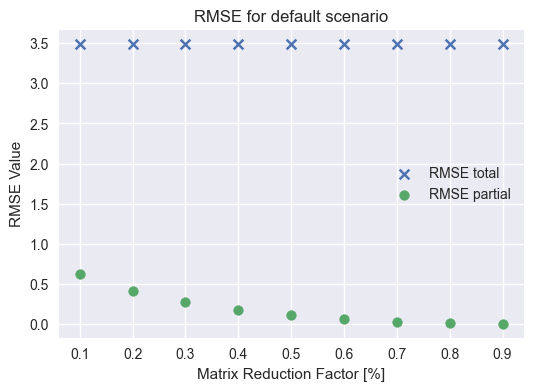

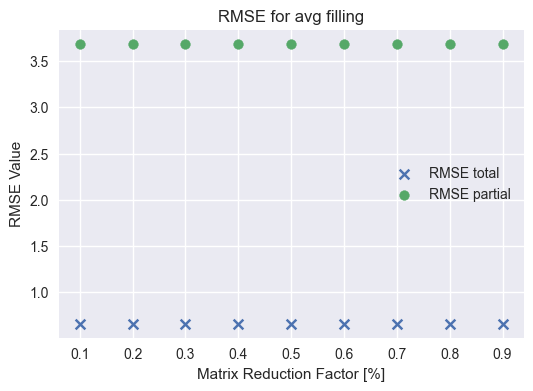

In [13]:
def plot_info(red_factor, title):

    total, partial = red_factor
    fig = plt.figure(figsize=(6,4))
    plt.title(title)
    plt.scatter(x=np.arange(0.1, 1, 0.1),y=total, marker='x', label='RMSE total')
    plt.scatter(x=np.arange(0.1, 1, 0.1),y= partial, label='RMSE partial')
    plt.ylabel("RMSE Value")
    plt.xlabel("Matrix Reduction Factor [%]")
    plt.legend()
    plt.show()

plot_info((red_factor_total_default, red_factor_partial_default), 'RMSE for default scenario')
plot_info((red_factor_total_avg, red_factor_partial_avg), 'RMSE for avg filling')


A few conclusions regarding each methods efficiency, the zero filling method presents low RMSE partial with a high RMSE total, which means the amount of zeros in the matrix are tainting the SVD performance on the task, this is, the SVD is "predicting" a lot of zeros and not being able to transfer real information to each rating. This result is somehow expected since the space segregated by the left ("user space") and right ("movie space") singular vectors can't indicate a proper linear combination of movies that is capable of represeting one without a real rating, this is, the empty spaces worsen the matrix decomposition. 

Now for the average filling method, the scenario is the opposite. A low RMSE total and a high RMSE partial. This means, the addition of a average prediction for movies the user haven't necessarily rated, induce a bias, differently from the zero's bias, this one makes the svd reconstruct better the reconstruct data, smoothing the importance of the real ratings.    


Both of this experiments induce one conclusion: SVD is capable of reconstructing data (even with lower dimensions) but it will reproduce bias in the data. 


---
## SVD Decomposition - KNN filled data

In [14]:
def svd_with_knninput(X, test_x, test_users, N):

    knn_imputer = KNNImputer(missing_values=0, n_neighbors=N, keep_empty_features=True)
    X_inputed = knn_imputer.fit_transform(X)

    u, sigma, vt = get_svd_matrices(X_inputed, np.linalg.svd)

    M = (u @ sigma) @ vt
    M_test = M[test_users]

    r_t, r_p = compare_svd_methods(M_test,test_x)

    return r_t, r_p


r_t_list, r_p_list = [], []
for N in np.arange(2,25, 5):
    print("N = ", N)
    r_t, r_p = svd_with_knninput(train_x, test_x, test_users, N)
    r_t_list.append(r_t)
    r_p_list.append(r_p)



N =  2
N =  7
N =  12
N =  17
N =  22


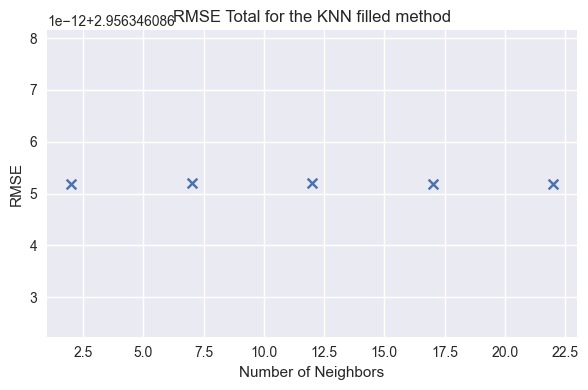

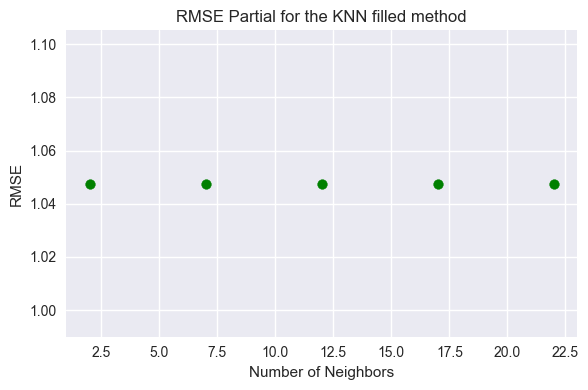

In [30]:
fig = plt.figure(figsize=(6,4))
plt.title("RMSE Total for the KNN filled method")
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE')

plt.scatter(np.arange(2,25,5), r_t_list, marker='x')
fig.tight_layout()
plt.show()


fig = plt.figure(figsize=(6,4))
plt.title("RMSE Partial for the KNN filled method")
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE')
plt.scatter(np.arange(2,25,5), r_p_list, color='g')
fig.tight_layout()

plt.show()


Applying a KNN to inpute the missing data in the matrix, have shown to be a good strategy to minimize the RMSE partial but it wasnt able to improve the $RMSE_t$, when compared with the simpler approaches (mean and zero filling) but it also presented a higher computational cost. At first is rational to imagine that a higher number of neighbors would provide a better filling, therefore a lower error. Therefore an experiment varying the number of neighbors has been done starting at 2 up to 20 in increments of 5, to minimize computation since this approach is resource consuming. The figures above represents both RMSE's agains the $N$ neighbors utilized to impute data, unexpectedly, it is a constant line with no relevant variation between neighbors.  

Other interesting analysis, is the difference between partial and total RMSE's, while the partial one decreased between the baseline, the total increased. Which means that filling up the missing data with the knn provides a better capacity to reproduce the existent data but not to the filled data itself

---
## SVD Decomposition - SVD filled

In [44]:
MISSING_ENTRIES = train_x == 0
NON_MISSING_ENTRIES = ~ MISSING_ENTRIES


def run_svd_softinpute(train_x, missing_entries_x, missing_entries_users, iter, l_thresh):

    X = np.copy(train_x)
    non_zero_indexes = np.nonzero(missing_entries_x)

    rmse_total_l , rmse_partial_l = [], []

    for i in range(iter):

        u, sigma, vt = get_svd_matrices(X, np.linalg.svd)

        # # soft thresholding 
        np.fill_diagonal(sigma, np.maximum(sigma.diagonal() - l_thresh, 0))

        M = (u @ sigma) @ vt
        M_missing_entries = M[missing_entries_users]

        r_t = root_mean_squared_error(missing_entries_x, M_missing_entries)
        r_p = root_mean_squared_error(missing_entries_x[non_zero_indexes], M_missing_entries[non_zero_indexes])

        rmse_total_l.append(r_t)
        rmse_partial_l.append(r_p)

        norm_diff = np.linalg.norm(X - M, ord='fro')
        # print(f'Epoch {i}>> norm diff {norm_diff:.4f}', end='\r')
        if norm_diff < 1e-1:
            print(f"Converged in {i} iterations.")
            break
         
        X[MISSING_ENTRIES] = M[MISSING_ENTRIES]


    return rmse_partial_l, rmse_total_l


In [17]:
rmse_partial_l, rmse_total_l = run_svd_softinpute(train_x, test_x, test_users, iter=160, l_thresh=20)
print(rmse_total_l[0], rmse_total_l[-1])
print(rmse_partial_l[0], rmse_partial_l[-1])

0.6600406081521569 0.6600406081521569
3.688607045489287 3.688607045489287


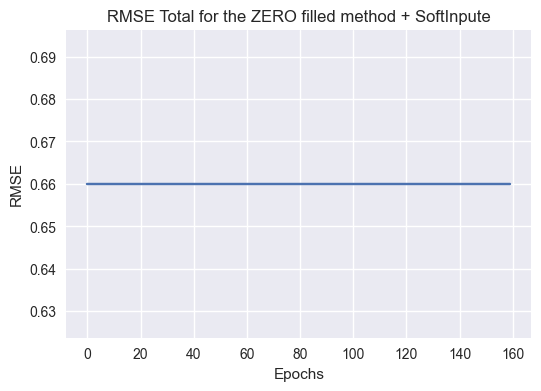

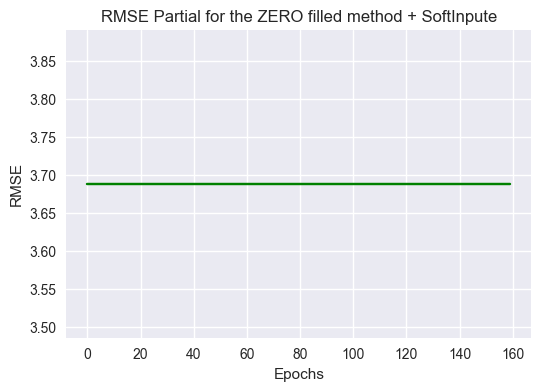

In [32]:

fig = plt.figure(figsize=(6,4))
plt.title("RMSE Total for the ZERO filled method + SoftInpute")
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.plot(rmse_total_l, marker='x')
plt.show()

fig = plt.figure(figsize=(6,4))
plt.title("RMSE Partial for the ZERO filled method + SoftInpute")
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.plot(rmse_partial_l, marker='x', color='g')
plt.show()

In [45]:
rmse_partial_l_200, rmse_total_l_200 = run_svd_softinpute(X_average, test_x, test_users, iter=160, l_thresh=200)


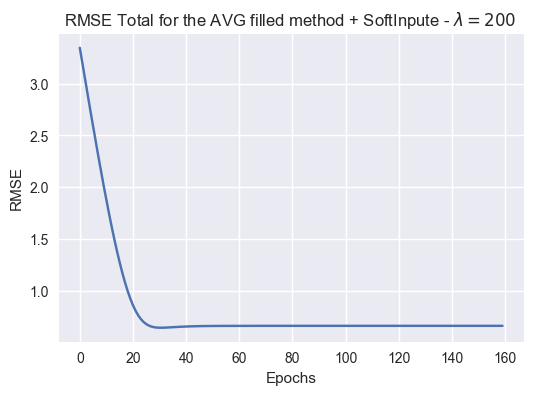

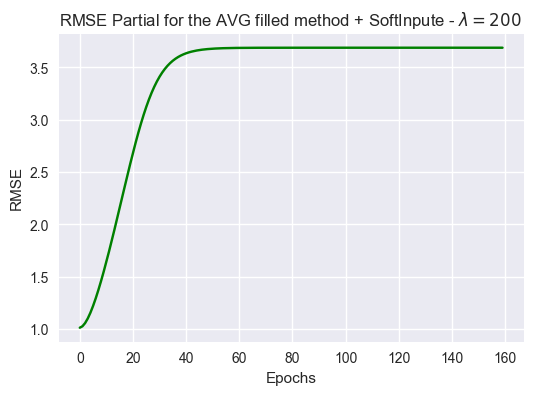

In [37]:
fig = plt.figure(figsize=(6,4))
plt.title("RMSE Total for the AVG filled method + SoftInpute - $\lambda = 200$ ")
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.plot(rmse_total_l_200, marker='x', )
plt.show()

fig = plt.figure(figsize=(6,4))
plt.title("RMSE Partial for the AVG filled method + SoftInpute - $\lambda = 200$ ")
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.plot(rmse_partial_l_200, marker='x', color='g')
plt.show()

In [19]:
rmse_partial_l_100, rmse_total_l_100 = run_svd_softinpute(X_average, test_x, test_users, iter=160, l_thresh=100)


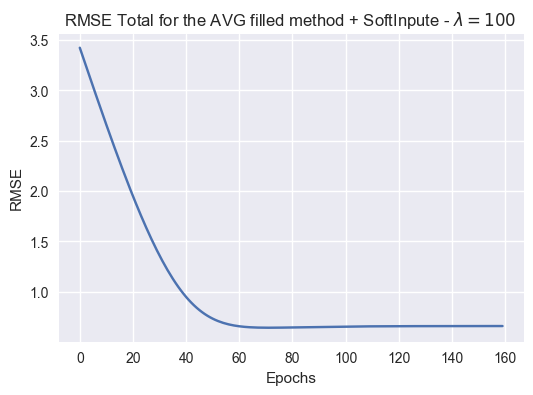

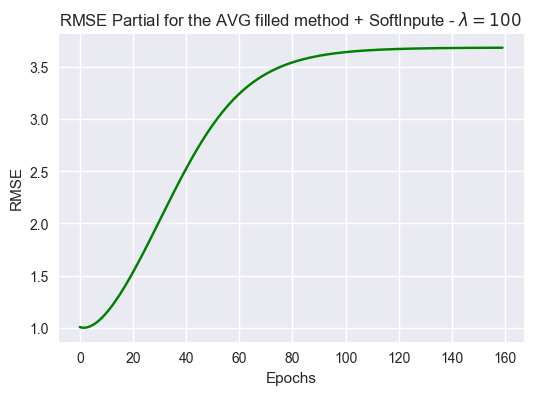

In [35]:
fig = plt.figure(figsize=(6,4))
plt.title("RMSE Total for the AVG filled method + SoftInpute - $\lambda = 100$ ")
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.plot(rmse_total_l_100, marker='x', )
plt.show()

fig = plt.figure(figsize=(6,4))
plt.title("RMSE Partial for the AVG filled method + SoftInpute - $\lambda = 100$ ")
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.plot(rmse_partial_l_100, marker='x', color='g')
plt.show()


In [21]:
rmse_partial_l_20, rmse_total_l_20 = run_svd_softinpute(X_average, test_x, test_users, iter=160, l_thresh=20)



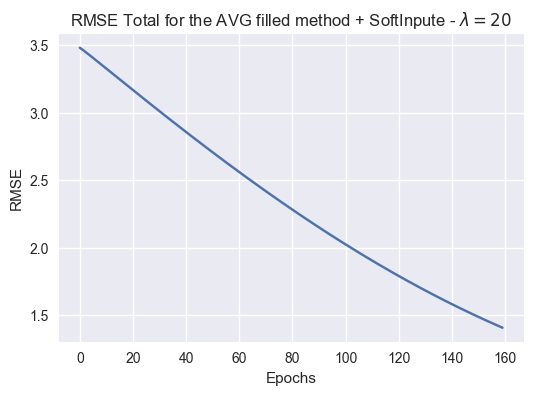

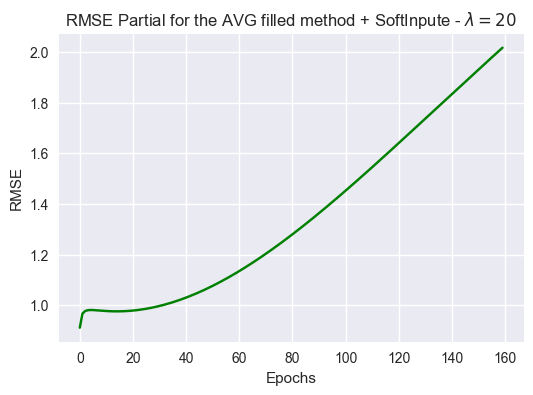

In [46]:
fig = plt.figure(figsize=(6,4))
plt.title("RMSE Total for the AVG filled method + SoftInpute - $\lambda = 20$ ")
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.plot(rmse_total_l_20, marker='x')
plt.show()


fig = plt.figure(figsize=(6,4))
plt.title("RMSE Partial for the AVG filled method + SoftInpute - $\lambda = 20$ ")
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.plot(rmse_partial_l_20, marker='x', color='g')
plt.show()


--- 
---

## Conclusions

The first two methods of inputting, Zero and AVG, have shown either low RMSE total or low RMSE partial, with little or no variation for the K percentage used for the SVD reconstruction.


As expected, the best approach was the Softimpute proposed by Hastie, when paired with the AVG filled data. For the ZERO filled matrix, the Softimpute did show no RMSE convergence, no matter the choosen $\lambda$, as a first guess the experiments were done with $\lambda = 20$ as proposed by the authors. To explore if a higher lambda would generate a faster decrease in the RMSE, two lambdas were tested $100$ and $200$. As expected, an increase in lambda made the inpute reach a plateau faster, around 25 and 45 iterations respectively, this behaviour could be predicted with a analyis of the soft thresholding operation $(D_{ii} - \lambda)_+$, where higher values of lambda leads the singular values to vanish faster.

Even though, the softimpute solution presents the lower RMSE total of all solutions it does come with a high RMSE partial, similar to the default filling, which indicates it may be only a good reconstruction tool if the values are already present. 



To conclude, the best method regarding computational efficiency and results is the KNN inpute as it shows the lower RMSE partial, which means its able to reproduce better  participants on the test set. 


